# 对POI兴趣点信息进行编码工作

## 地理位置信息编码

In [1]:
import h3
import numpy as np
import torch
from collections import defaultdict
import json

print("=" * 60)
print("🗺️  H3 地理位置编码 (多分辨率)")
print("=" * 60)

# 1. 准备数据

with open('data/poi_data_more_precise.json', 'r', encoding='utf-8') as f:
    pois = json.load(f)
    
locations = {poi['id']: (poi['lat'], poi['lon']) for poi in pois}

with open('data/house_data.json', 'r', encoding='utf-8') as f:
    houses = json.load(f)

locations.update({"house" + str(house['id']): (float(house['lat']), float(house['lon'])) for house in houses})

lat = np.array([loc[0] for loc in locations.values()])
lon = np.array([loc[1] for loc in locations.values()])
resolutions = [5, 7, 9]  # 粗、中、细分辨率


🗺️  H3 地理位置编码 (多分辨率)


In [2]:
# 2. 生成 H3 单元（多分辨率）
cells = {
    r: [h3.latlng_to_cell(lt, ln, r) for lt, ln in zip(lat, lon)]
    for r in resolutions
}


# 3. 建立全局映射（跨分辨率共享词表）
cell2idx = defaultdict(lambda: len(cell2idx))
idxs = {
    r: [cell2idx[c] for c in cells[r]]
    for r in resolutions
}
    
# 4. 嵌入层（每个分辨率独立）
embedding_dim = 8
embedding_r = {
    r: torch.nn.Embedding(len(cell2idx), embedding_dim)
    for r in resolutions
}

# 5. 查询并拼接多分辨率嵌入
vecs = [
    embedding_r[r](torch.tensor(idxs[r]))
    for r in resolutions
]
embedding_vector = torch.cat(vecs, dim=-1)

In [3]:
# ✅ 6. 建立 ID 到向量的映射
id_to_vector_idx = {
    node_id: idx 
    for idx, node_id in enumerate(locations.keys())
}

# ✅ 7. 查询函数
def get_embedding_by_id(node_id):
    """
    根据 POI ID 或 House ID 查询嵌入向量
    
    参数:
        node_id: POI ID (字符串) 或 House ID (如 "house123")
    
    返回:
        torch.Tensor: 嵌入向量 (shape: [48])
    """
    if node_id not in id_to_vector_idx:
        raise KeyError(f"节点 {node_id} 不存在！")
    
    idx = id_to_vector_idx[node_id]
    return embedding_vector[idx]

### 结果验证

In [11]:
# 计算相似度
from torch.nn.functional import cosine_similarity
a = get_embedding_by_id("relation/14142832")
b = get_embedding_by_id("node/3814799022")
sim = cosine_similarity(a.unsqueeze(0), b.unsqueeze(0))
print(f"余弦相似度: {sim.item():.4f}")

余弦相似度: -0.2230


## POI信息编码

In [1]:
import json
import torch
import torch.nn as nn
import numpy as np
from collections import defaultdict

print("=" * 60)
print("🏠 构建 POI 类型嵌入 → 房价预测模型")
print("=" * 60)

# 1. 加载数据
print("\n📦 加载数据...")
with open('data/poi_house_data_more_precise.json', 'r', encoding='utf-8') as f:
    poi_house_data = json.load(f)

# 2. 提取所有 POI 类型并建立词表
print("📚 构建 POI 类型词表...")
poi_type_set = set()
for poi in poi_house_data:
    poi_type_set.add(poi['first_tag'] + '_' + poi['second_tag'])

poi_type2idx = {pt: idx for idx, pt in enumerate(sorted(poi_type_set))}
poi_type2idx['<UNK>'] = len(poi_type2idx)  # 未知类型

print(f"✅ POI 类型总数: {len(poi_type2idx)}")
print(f"   示例类型: {list(poi_type2idx.keys())[:10]}")

# 3. 准备训练数据
print("\n🔧 准备训练数据...")
X_poi_types = []  # 每个房屋周边的 POI 类型列表
X_poi_counts = []  # 每种类型的数量
y_prices = []     # 房价标签

for poi in poi_house_data:
    if not poi.get('nearby_houses') or poi.get('average_nearby_house_price') is None:
        continue
    
    # 统计周边 POI 类型分布
    type_counter = defaultdict(int)

    poi_type = poi['first_tag'] + '_' + poi['second_tag']
    if poi_type not in poi_type2idx:
        poi_type = '<UNK>'
    type_counter[poi_type] += 1
    
    # 转换为索引和计数向量
    types_idx = [poi_type2idx[t] for t in type_counter.keys()]
    counts = [type_counter[t] for t in type_counter.keys()]
    
    X_poi_types.append(types_idx)
    X_poi_counts.append(counts)
    y_prices.append(float(poi['average_nearby_house_price']))

print(f"✅ 训练样本数: {len(y_prices):,}")
print(f"   价格范围: {min(y_prices):.0f} - {max(y_prices):.0f} 元/㎡")
print(f"   平均价格: {np.mean(y_prices):.0f} 元/㎡")

🏠 构建 POI 类型嵌入 → 房价预测模型

📦 加载数据...
📚 构建 POI 类型词表...
✅ POI 类型总数: 364
   示例类型: ['aeroway_aerodrome', 'aeroway_apron', 'aeroway_hangar', 'aeroway_helipad', 'aeroway_navigationaid', 'aeroway_parking_position', 'aeroway_runway', 'aeroway_stopway', 'aeroway_taxiway', 'aeroway_windsock']

🔧 准备训练数据...
✅ 训练样本数: 40,887
   价格范围: 6139 - 70006 元/㎡
   平均价格: 29481 元/㎡
📚 构建 POI 类型词表...
✅ POI 类型总数: 364
   示例类型: ['aeroway_aerodrome', 'aeroway_apron', 'aeroway_hangar', 'aeroway_helipad', 'aeroway_navigationaid', 'aeroway_parking_position', 'aeroway_runway', 'aeroway_stopway', 'aeroway_taxiway', 'aeroway_windsock']

🔧 准备训练数据...
✅ 训练样本数: 40,887
   价格范围: 6139 - 70006 元/㎡
   平均价格: 29481 元/㎡


In [2]:
# 4. 定义端到端模型
class POITypePricePredictor(nn.Module):
    """
    端到端 POI 类型嵌入 → 房价预测模型
    
    架构:
    1. POI 类型嵌入层 (可学习)
    2. 聚合层 (加权平均)
    3. MLP 预测层
    """
    def __init__(self, num_poi_types, embedding_dim=32, hidden_dim=128):
        super().__init__()
        
        # POI 类型嵌入层 (这里学习每种 POI 类型的特征表示)
        self.poi_type_embedding = nn.Embedding(num_poi_types, embedding_dim)
        
        # 注意力权重层 (学习不同 POI 类型对房价的重要性)
        self.attention = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Softmax(dim=0)
        )
        
        # 预测头 (MLP)
        self.predictor = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    
    def forward(self, poi_types_list, poi_counts_list):
        """
        参数:
            poi_types_list: List[List[int]], 每个样本的 POI 类型索引列表
            poi_counts_list: List[List[int]], 每个样本的 POI 类型计数列表
        
        返回:
            predicted_prices: torch.Tensor, shape [batch_size, 1]
        """
        batch_embeddings = []
        
        for poi_types, poi_counts in zip(poi_types_list, poi_counts_list):
            if len(poi_types) == 0:
                # 如果没有 POI，使用零向量
                batch_embeddings.append(torch.zeros(self.poi_type_embedding.embedding_dim))
                continue
            
            # 获取嵌入向量
            types_tensor = torch.tensor(poi_types, dtype=torch.long)
            counts_tensor = torch.tensor(poi_counts, dtype=torch.float32)
            
            embeddings = self.poi_type_embedding(types_tensor)  # [num_types, embedding_dim]
            
            # 注意力加权聚合
            attention_weights = self.attention(embeddings)  # [num_types, 1]
            
            # 结合计数信息
            counts_normalized = counts_tensor / counts_tensor.sum()  # 归一化计数
            combined_weights = attention_weights.squeeze() * counts_normalized
            combined_weights = combined_weights / combined_weights.sum()  # 重新归一化
            
            # 加权平均
            aggregated = (embeddings.T @ combined_weights.unsqueeze(1)).squeeze()  # [embedding_dim]
            batch_embeddings.append(aggregated)
        
        # 堆叠成批次
        batch_embeddings = torch.stack(batch_embeddings)  # [batch_size, embedding_dim]
        
        # 预测房价
        predicted_prices = self.predictor(batch_embeddings)
        
        return predicted_prices

# 初始化模型
model = POITypePricePredictor(
    num_poi_types=len(poi_type2idx),
    embedding_dim=32,
    hidden_dim=128
)

print("\n🧠 模型架构:")
print(model)
print(f"\n📊 模型参数:")
print(f"   POI 类型数: {len(poi_type2idx)}")
print(f"   嵌入维度: 32")
print(f"   总参数量: {sum(p.numel() for p in model.parameters()):,}")


🧠 模型架构:
POITypePricePredictor(
  (poi_type_embedding): Embedding(364, 32)
  (attention): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Softmax(dim=0)
  )
  (predictor): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

📊 模型参数:
   POI 类型数: 364
   嵌入维度: 32
   总参数量: 26,370


In [3]:
# 5. 训练配置
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# 数据归一化 (房价)
y_prices_array = np.array(y_prices)
price_mean = y_prices_array.mean()
price_std = y_prices_array.std()
y_normalized = (y_prices_array - price_mean) / price_std

# 划分训练/验证集
X_types_train, X_types_val, X_counts_train, X_counts_val, y_train, y_val = train_test_split(
    X_poi_types, X_poi_counts, y_normalized, test_size=0.2, random_state=42
)

print("📊 数据划分:")
print(f"   训练集: {len(X_types_train):,} 样本")
print(f"   验证集: {len(X_types_val):,} 样本")

# 自定义 Dataset
class POIHouseDataset(Dataset):
    def __init__(self, poi_types, poi_counts, prices):
        self.poi_types = poi_types
        self.poi_counts = poi_counts
        self.prices = prices
    
    def __len__(self):
        return len(self.prices)
    
    def __getitem__(self, idx):
        return self.poi_types[idx], self.poi_counts[idx], self.prices[idx]

# 自定义 collate_fn (处理变长序列)
def collate_fn(batch):
    poi_types_list = [item[0] for item in batch]
    poi_counts_list = [item[1] for item in batch]
    prices = torch.tensor([item[2] for item in batch], dtype=torch.float32)
    return poi_types_list, poi_counts_list, prices

# 数据加载器
train_dataset = POIHouseDataset(X_types_train, X_counts_train, y_train)
val_dataset = POIHouseDataset(X_types_val, X_counts_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# 优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

print("\n⚙️  训练配置:")
print(f"   优化器: Adam (lr=0.001)")
print(f"   损失函数: MSE")
print(f"   批次大小: 32")
print(f"   训练批次数: {len(train_loader)}")

📊 数据划分:
   训练集: 32,709 样本
   验证集: 8,178 样本

⚙️  训练配置:
   优化器: Adam (lr=0.001)
   损失函数: MSE
   批次大小: 32
   训练批次数: 1023

⚙️  训练配置:
   优化器: Adam (lr=0.001)
   损失函数: MSE
   批次大小: 32
   训练批次数: 1023


In [4]:
# 6. 训练循环
import time

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for poi_types, poi_counts, prices in loader:
        optimizer.zero_grad()
        predictions = model(poi_types, poi_counts).squeeze()
        loss = criterion(predictions, prices)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for poi_types, poi_counts, prices in loader:
            predictions = model(poi_types, poi_counts).squeeze()
            loss = criterion(predictions, prices)
            total_loss += loss.item()
            all_preds.extend(predictions.numpy())
            all_targets.extend(prices.numpy())
    
    return total_loss / len(loader), np.array(all_preds), np.array(all_targets)

# 训练
print("\n" + "=" * 60)
print("🚀 开始训练...")
print("=" * 60)

num_epochs = 50
best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_preds, val_targets = validate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # 早停
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'data/poi_type_price_model_best.pt')
    else:
        patience_counter += 1
    
    if epoch % 5 == 0:
        # 反归一化计算真实误差
        val_preds_real = val_preds * price_std + price_mean
        val_targets_real = val_targets * price_std + price_mean
        mae = np.mean(np.abs(val_preds_real - val_targets_real))
        
        print(f"Epoch {epoch:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"MAE: {mae:.0f} 元/㎡")
    
    if patience_counter >= patience:
        print(f"\n⚠️  验证损失连续 {patience} 轮未改善，提前停止训练")
        break

total_time = time.time() - start_time

print("\n" + "=" * 60)
print(f"✅ 训练完成！")
print(f"   总耗时: {total_time:.2f} 秒")
print(f"   最佳验证损失: {best_val_loss:.4f}")
print(f"   最终轮数: {epoch}/{num_epochs}")
print("=" * 60)


🚀 开始训练...
Epoch   5/50 | Train Loss: 0.8305 | Val Loss: 0.8153 | MAE: 6743 元/㎡
Epoch   5/50 | Train Loss: 0.8305 | Val Loss: 0.8153 | MAE: 6743 元/㎡
Epoch  10/50 | Train Loss: 0.8243 | Val Loss: 0.8127 | MAE: 6741 元/㎡
Epoch  10/50 | Train Loss: 0.8243 | Val Loss: 0.8127 | MAE: 6741 元/㎡
Epoch  15/50 | Train Loss: 0.8218 | Val Loss: 0.8084 | MAE: 6701 元/㎡
Epoch  15/50 | Train Loss: 0.8218 | Val Loss: 0.8084 | MAE: 6701 元/㎡
Epoch  20/50 | Train Loss: 0.8213 | Val Loss: 0.8115 | MAE: 6688 元/㎡
Epoch  20/50 | Train Loss: 0.8213 | Val Loss: 0.8115 | MAE: 6688 元/㎡
Epoch  25/50 | Train Loss: 0.8203 | Val Loss: 0.8082 | MAE: 6695 元/㎡
Epoch  25/50 | Train Loss: 0.8203 | Val Loss: 0.8082 | MAE: 6695 元/㎡
Epoch  30/50 | Train Loss: 0.8187 | Val Loss: 0.8094 | MAE: 6712 元/㎡
Epoch  30/50 | Train Loss: 0.8187 | Val Loss: 0.8094 | MAE: 6712 元/㎡
Epoch  35/50 | Train Loss: 0.8185 | Val Loss: 0.8083 | MAE: 6691 元/㎡

⚠️  验证损失连续 10 轮未改善，提前停止训练

✅ 训练完成！
   总耗时: 106.96 秒
   最佳验证损失: 0.8082
   最终轮数: 35/50
Epoch 


📊 模型性能评估 (验证集):
   MAE:  6695.35 元/㎡
   RMSE: 8353.79 元/㎡
   MAPE: 27.73%


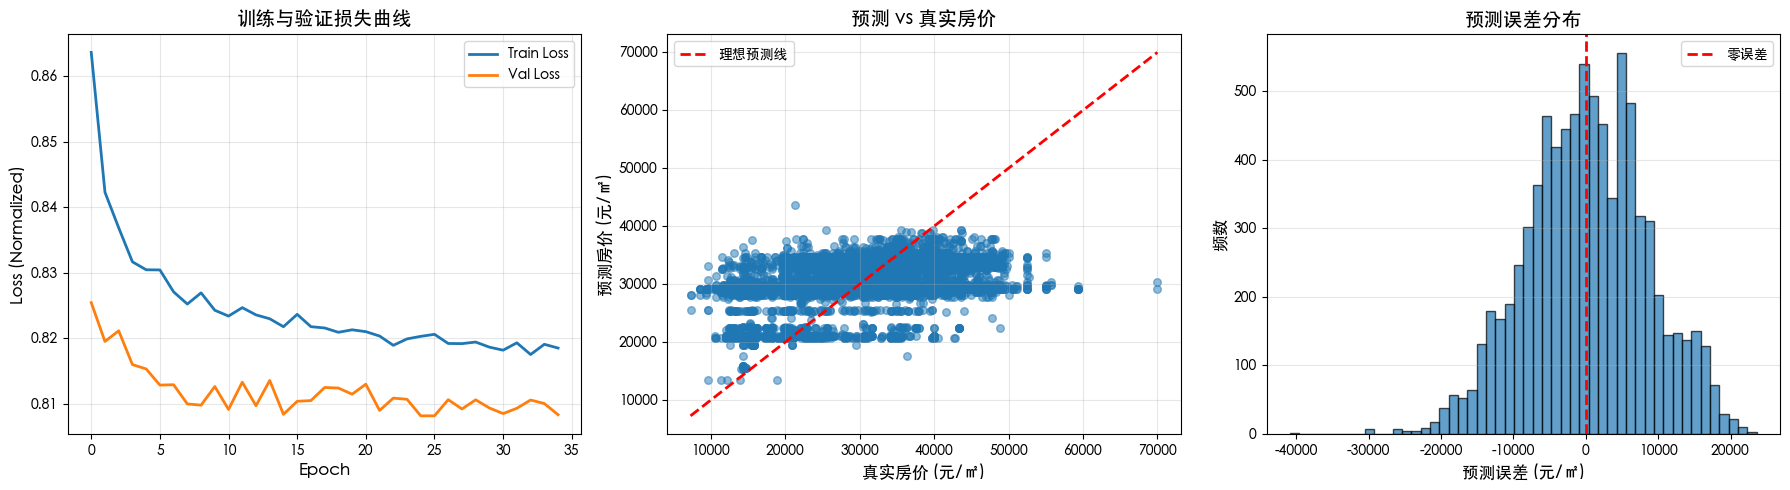


💾 可视化结果已保存至: image/poi_type_price_prediction_results.png


In [5]:
# 7. 结果评估与可视化
import matplotlib.pyplot as plt
# macOS 推荐字体
plt.rcParams['font.family'] = 'Heiti TC'
plt.rcParams['axes.unicode_minus'] = False
# 加载最佳模型
model.load_state_dict(torch.load('data/poi_type_price_model_best.pt'))

# 验证集预测
_, val_preds, val_targets = validate(model, val_loader, criterion)

# 反归一化
val_preds_real = val_preds * price_std + price_mean
val_targets_real = val_targets * price_std + price_mean

# 计算指标
mae = np.mean(np.abs(val_preds_real - val_targets_real))
rmse = np.sqrt(np.mean((val_preds_real - val_targets_real)**2))
mape = np.mean(np.abs((val_preds_real - val_targets_real) / val_targets_real)) * 100

print("\n📊 模型性能评估 (验证集):")
print(f"   MAE:  {mae:.2f} 元/㎡")
print(f"   RMSE: {rmse:.2f} 元/㎡")
print(f"   MAPE: {mape:.2f}%")

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. 训练曲线
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (Normalized)', fontsize=12)
axes[0].set_title('训练与验证损失曲线', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. 预测 vs 真实
axes[1].scatter(val_targets_real, val_preds_real, alpha=0.5, s=30)
axes[1].plot([val_targets_real.min(), val_targets_real.max()], 
             [val_targets_real.min(), val_targets_real.max()], 
             'r--', linewidth=2, label='理想预测线')
axes[1].set_xlabel('真实房价 (元/㎡)', fontsize=12)
axes[1].set_ylabel('预测房价 (元/㎡)', fontsize=12)
axes[1].set_title('预测 vs 真实房价', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. 误差分布
errors = val_preds_real - val_targets_real
axes[2].hist(errors, bins=50, alpha=0.7, edgecolor='black')
axes[2].axvline(0, color='red', linestyle='--', linewidth=2, label='零误差')
axes[2].set_xlabel('预测误差 (元/㎡)', fontsize=12)
axes[2].set_ylabel('频数', fontsize=12)
axes[2].set_title('预测误差分布', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('image/poi_type_price_prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 可视化结果已保存至: image/poi_type_price_prediction_results.png")


🔍 学习到的 POI 类型权重分析

🏆 Top 20 对房价影响最大的 POI 类型:
排名     POI 类型                         影响力分数          
------------------------------------------------------------
1      shop_convenience               4.9973
2      amenity_bicycle_parking        4.8512
3      amenity_cafe                   4.5202
4      amenity_taxi                   4.2325
5      railway_rail                   4.2066
6      railway_switch                 4.1517
7      public_transport_platform      4.1007
8      railway_disused                4.1006
9      amenity_bar                    4.0980
10     shop_supermarket               4.0952
11     amenity_atm                    4.0400
12     amenity_school                 4.0082
13     office_estate_agent            3.9955
14     tourism_motel                  3.9915
15     leisure_park                   3.9900
16     leisure_fitness_centre         3.9839
17     amenity_bank                   3.9779
18     railway_buffer_stop            3.9106
19     amenity_restaurant    

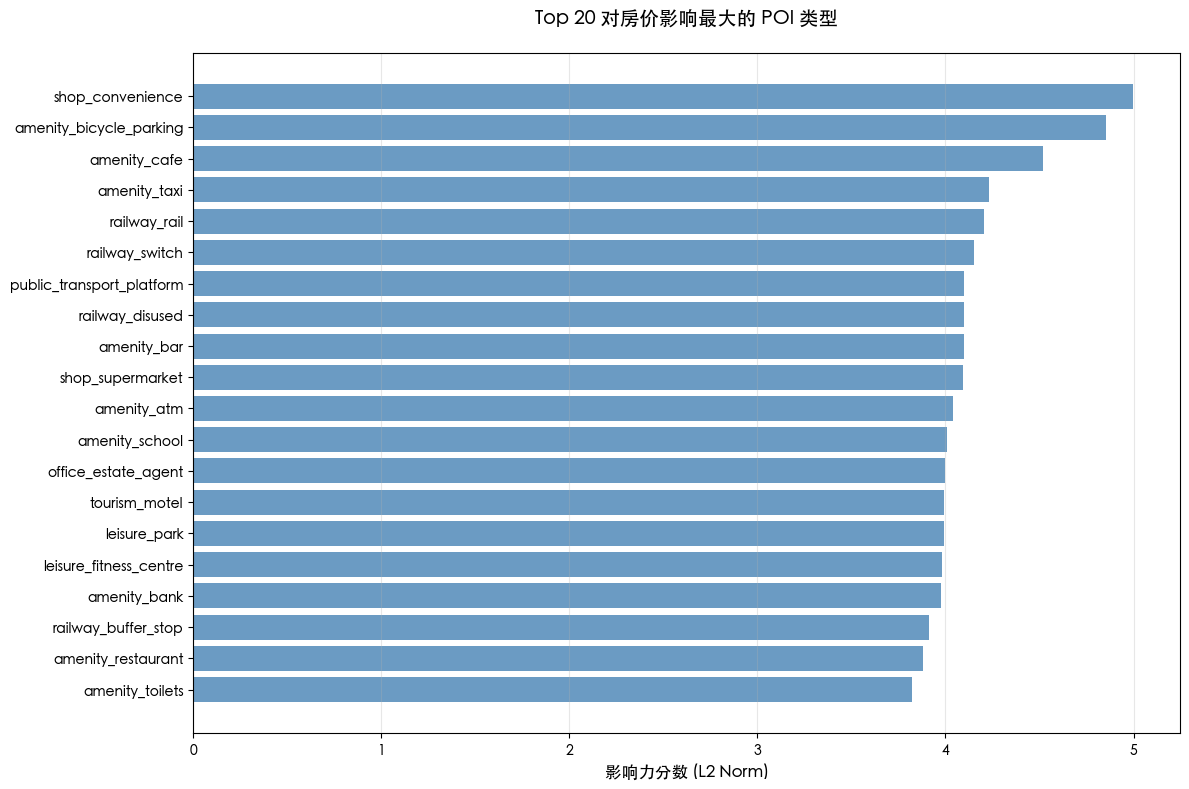


💾 排名图已保存至: image/poi_type_importance_ranking.png


In [6]:
# 8. 分析学习到的 POI 类型权重
print("\n" + "=" * 60)
print("🔍 学习到的 POI 类型权重分析")
print("=" * 60)

# 提取嵌入向量
poi_embeddings = model.poi_type_embedding.weight.detach().numpy()

# 计算每种 POI 类型的"房价影响力"（嵌入向量的 L2 范数）
poi_importance = np.linalg.norm(poi_embeddings, axis=1)

# 反向映射
idx2poi_type = {idx: pt for pt, idx in poi_type2idx.items()}

# 排序
poi_importance_sorted = sorted(
    [(idx2poi_type[i], poi_importance[i]) for i in range(len(poi_importance))],
    key=lambda x: x[1],
    reverse=True
)

# 显示 Top 20 最重要的 POI 类型
print("\n🏆 Top 20 对房价影响最大的 POI 类型:")
print(f"{'排名':<6} {'POI 类型':<30} {'影响力分数':<15}")
print("-" * 60)
for rank, (poi_type, score) in enumerate(poi_importance_sorted[:20], 1):
    print(f"{rank:<6} {poi_type:<30} {score:.4f}")

# 显示 Bottom 10（影响最小）
print(f"\n⬇️ Bottom 10 对房价影响最小的 POI 类型:")
print(f"{'排名':<6} {'POI 类型':<30} {'影响力分数':<15}")
print("-" * 60)
for rank, (poi_type, score) in enumerate(poi_importance_sorted[-10:], 1):
    print(f"{rank:<6} {poi_type:<30} {score:.4f}")

# 可视化 Top 20
import matplotlib.pyplot as plt

top_20_types = [item[0] for item in poi_importance_sorted[:20]]
top_20_scores = [item[1] for item in poi_importance_sorted[:20]]

plt.figure(figsize=(12, 8))
plt.barh(range(20), top_20_scores, color='steelblue', alpha=0.8)
plt.yticks(range(20), top_20_types, fontsize=10)
plt.xlabel('影响力分数 (L2 Norm)', fontsize=12, fontweight='bold')
plt.title('Top 20 对房价影响最大的 POI 类型', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('image/poi_type_importance_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 排名图已保存至: image/poi_type_importance_ranking.png")

In [ ]:
# 9. 保存模型和嵌入
import pickle

# 保存完整模型
torch.save({
    'model_state_dict': model.state_dict(),
    'poi_type2idx': poi_type2idx,
    'poi_embeddings': poi_embeddings,
    'price_mean': price_mean,
    'price_std': price_std,
    'model_config': {
        'num_poi_types': len(poi_type2idx),
        'embedding_dim': 32,
        'hidden_dim': 128
    }
}, 'data/poi_type_price_model_complete.pt')

# 保存 POI 类型权重排名
poi_type_weights = {
    'poi_importance': dict(poi_importance_sorted),
    'poi_embeddings': poi_embeddings,
    'poi_type2idx': poi_type2idx
}

with open('data/poi_type_weights.pkl', 'wb') as f:
    pickle.dump(poi_type_weights, f)

print("=" * 60)
print("💾 保存文件:")
print("   - data/poi_type_price_model_complete.pt (完整模型)")
print("   - data/poi_type_price_model_best.pt (最佳权重)")
print("   - data/poi_type_weights.pkl (POI 类型权重)")
print("=" * 60)

print("\n✅ 训练完成！模型已成功学习 POI 类型对房价的影响权重！")

### 使用训练好的模型进行预测

In [ ]:
# 10. 使用示例：预测新房屋的价格
def predict_house_price(model, poi_types_nearby, poi_counts_nearby, price_mean, price_std):
    """
    根据周边 POI 类型预测房价
    
    参数:
        model: 训练好的模型
        poi_types_nearby: List[str], POI 类型列表 (如 ['restaurant', 'school'])
        poi_counts_nearby: List[int], 对应的 POI 数量
        price_mean, price_std: 归一化参数
    
    返回:
        predicted_price: float, 预测的房价 (元/㎡)
    """
    model.eval()
    
    # 转换为索引
    poi_indices = [poi_type2idx.get(pt, poi_type2idx['<UNK>']) for pt in poi_types_nearby]
    
    with torch.no_grad():
        # 批次大小为 1
        prediction_normalized = model([poi_indices], [poi_counts_nearby]).item()
        
        # 反归一化
        prediction_real = prediction_normalized * price_std + price_mean
    
    return prediction_real

# 测试用例
print("\n" + "=" * 60)
print("🏠 预测示例")
print("=" * 60)

# 示例 1: 高端区域（学校、医院、商场多）
poi_types_1 = ['school', 'hospital', 'shopping_mall', 'subway', 'park']
poi_counts_1 = [3, 2, 2, 1, 1]

price_1 = predict_house_price(model, poi_types_1, poi_counts_1, price_mean, price_std)
print(f"\n📍 示例 1 - 高端区域:")
print(f"   周边 POI: {dict(zip(poi_types_1, poi_counts_1))}")
print(f"   预测房价: {price_1:.0f} 元/㎡")

# 示例 2: 普通区域（超市、餐厅为主）
poi_types_2 = ['supermarket', 'restaurant', 'convenience_store']
poi_counts_2 = [2, 5, 3]

price_2 = predict_house_price(model, poi_types_2, poi_counts_2, price_mean, price_std)
print(f"\n📍 示例 2 - 普通区域:")
print(f"   周边 POI: {dict(zip(poi_types_2, poi_counts_2))}")
print(f"   预测房价: {price_2:.0f} 元/㎡")

# 示例 3: 偏远区域（POI 稀少）
poi_types_3 = ['convenience_store']
poi_counts_3 = [1]

price_3 = predict_house_price(model, poi_types_3, poi_counts_3, price_mean, price_std)
print(f"\n📍 示例 3 - 偏远区域:")
print(f"   周边 POI: {dict(zip(poi_types_3, poi_counts_3))}")
print(f"   预测房价: {price_3:.0f} 元/㎡")

print("\n" + "=" * 60)